# Package Installation and Importing Libraries

In [ ]:
!pip install qiskit
!pip install pylatexenc
!pip install qiskit-aer
from qiskit import *
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator, Statevector
from qiskit_aer import AerSimulator
import math
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=a67afed14e30d4c8f1352e88cbff9926d2e62bfcf411b0e9a948299489f1a9fa
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.6 MB/s eta 0:00:00


# QIP using QET

In [ ]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)

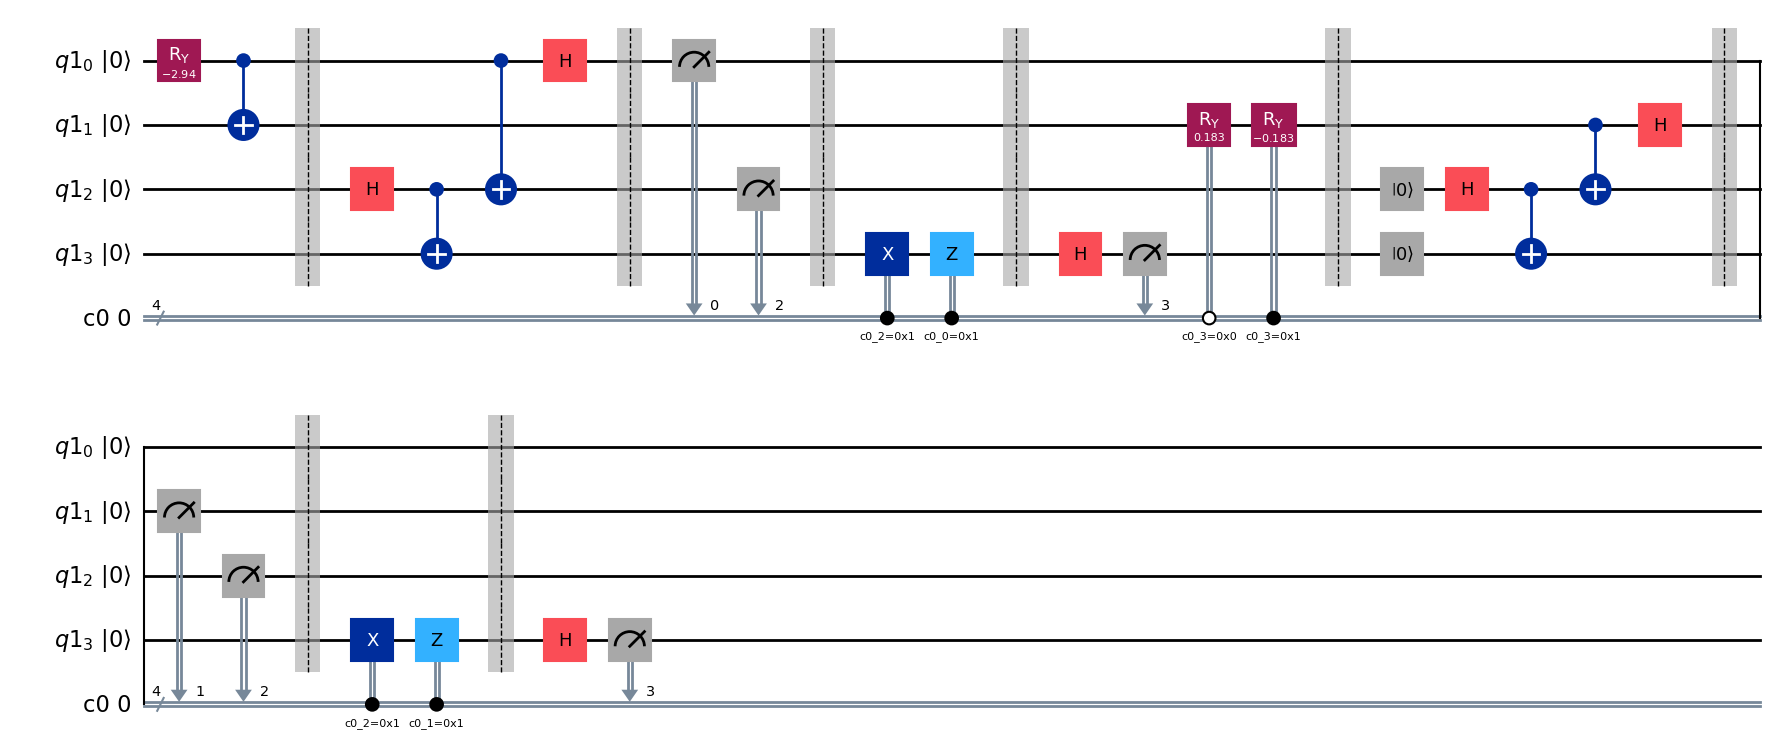

In [ ]:
qc = QuantumCircuit(qr, cr)

# Define the parameters (k, h)
k=0.2
h=1

#Prepare the ground state
alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

qc.ry(2*alpha,qr[0])
qc.cx(qr[0],qr[1]) #0 is control and 1 is the target
qc.barrier()

## quantum state teleportation of qr[0] (witness qubit) to qr[3] (Alice)

# Step 1: Create an entangled pair between qr[2] and qr[3]
qc.h(qr[2]) # Apply Hadamard gate on qubit 2
qc.cx(qr[2],qr[3]) # Apply CNOT gate with qubit 2 as control and qubit 3 as target


# Step 2: Apply CNOT gate between qr[0] and qr[2] with qr[0] as control
qc.cx(qr[0],qr[2])

# Step 3: Apply Hadamard gate on qr[0]
qc.h(qr[0])
qc.barrier()

# Step 4: Measure qr[0] and qr[2]
qc.measure(qr[0],cr[0])
qc.measure(qr[2],cr[2]) # Measure qubit 0 and 2 and store result in classical bits 0 and 2
qc.barrier()

# Step 5: Apply conditional gates on qr[3] based on the measurement results
qc.x(qr[3]).c_if(cr[2], 1) # Apply X gate to qr[3] if cr[2] is 1
qc.z(qr[3]).c_if(cr[0], 1) # Apply Z gate to qr[3] if cr[0] is 1
qc.barrier()

qc.h(qr[3]) # For measurement in X Basis
qc.measure(qr[3], cr[3]) # Measure the teleported qubit (qr[3]) and store the result in cr[3]




## Conditional Operation of Bob on 2nd qubit (qr[1]) based on the result Alice got (u = -1 or 1)

# fucntion for calculating sin(2*phi)
def sin(k,h):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2) #formula for sin(2*phi)

#Bob calculates phi for conditional operation

phi=0.5*np.arcsin(sin(k,h))

# Conditional Operation

qc.ry(2*phi,qr[1]).c_if(cr[3], 0) #for positive value post measurement
qc.ry(-2*phi,qr[1]).c_if(cr[3], 1) #for negative value

qc.barrier()

## Bob Teleports the second qubit (qr[1]) to Alice

# We reset qr[2] and qr[3] so that we can reuse them for second teleportation

qc.reset(qr[2])
qc.reset(qr[3])

# QST of first qubit (qr[1]) to 4th qubit (qr[3]) i.e to Alice

# Step 1: Create an entangled pair between qr[2] and qr[3]
qc.h(qr[2]) # Apply Hadamard gate on qubit 2
qc.cx(qr[2],qr[3]) # Apply CNOT gate with qubit 2 as control and qubit 3 as target


# Step 2: Apply CNOT gate between qr[1] and qr[2] with qr[1] as control
qc.cx(qr[1],qr[2])

# Step 3: Apply Hadamard gate on qr[1]
qc.h(qr[1])
qc.barrier()

# Step 4: Measure qr[1] and qr[2]
qc.measure(qr[1],cr[1])
qc.measure(qr[2],cr[2]) # Measure qubit 1 and 2 and store result in classical bits 1 and 2
qc.barrier()

# Step 5: Apply conditional gates on qr[3] based on the measurement results
qc.x(qr[3]).c_if(cr[2], 1) # Apply X gate to qr[3] if cr[2] is 1
qc.z(qr[3]).c_if(cr[1], 1) # Apply Z gate to qr[3] if cr[1] is 1
qc.barrier()

# Alice measures the teleported qubit on X basis for caluclating V (interaction energy)

qc.h(qr[3])
qc.measure(qr[3], cr[3]) # Measure the teleported qubit (qr[3]) and store the result in cr[3]

qc.draw(output='mpl',initial_state = True)

In [ ]:
# Transpile and run the circuit on a simulator
n_shots=100000

circ = transpile(qc, AerSimulator())
result = AerSimulator().run(circ, shots=n_shots).result()
counts = result.get_counts(circ)

## Energy Calculation

# We are interested in the state of qr[3] after the second teleportation and measurement.
# We can analyze the counts to determine the probability of measuring 0 or 1 in cr[3] after the second teleportation.

# Extract the counts for the cr[3] bit
cr3_counts = {}
for key, value in counts.items():
    cr3_value = key[-1]  # The last bit represents the measurement of cr[3]
    if cr3_value not in cr3_counts:       # If cr3_value = 0 [last bit of measurement is 0] and it is not in cr3_counts then this cr3_value = 0 will be initialized in cr3_counts with 0. i.e cr3_counts[0] = 0
        cr3_counts[cr3_value] = 0
    cr3_counts[cr3_value] += value

print("cr3_counts ['0'] = ",cr3_counts['0'])
print("cr3_counts ['1'] = ",cr3_counts['1'])

# Calculate the probabilities of measuring 0 or 1 in cr[3]
p_0 = cr3_counts.get('0', 0) / n_shots
p_1 = cr3_counts.get('1', 0) / n_shots



energy_qr3 = p_0 - p_1


print("Probability of measuring 0 in cr[3]:", p_0)
print("Probability of measuring 1 in cr[3]:", p_1)
print("Energy of qr[3] after measurement:", energy_qr3)

cr3_counts ['0'] =  49973
cr3_counts ['1'] =  50027
Probability of measuring 0 in cr[3]: 0.49973
Probability of measuring 1 in cr[3]: 0.50027
Energy of qr[3] after measurement: -0.0005399999999999849


# Circuit according to Dr. Kazuki Ikeda

Circuit according to IKEDA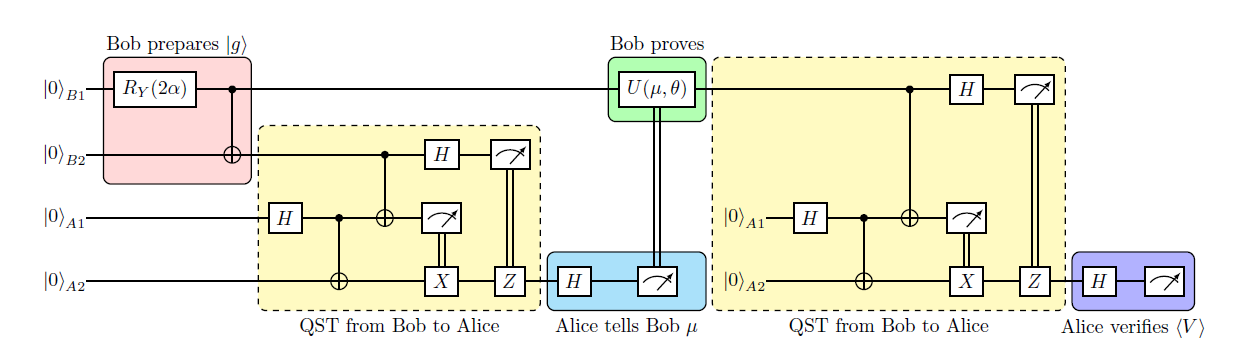

The difference is that in this circuit shown in the paper, the second qubit (B2) is teleported first instead of the first qubit (B1) even though the algorithm states that Bob teleports the witness qubit (first qubit) first.

In [ ]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)

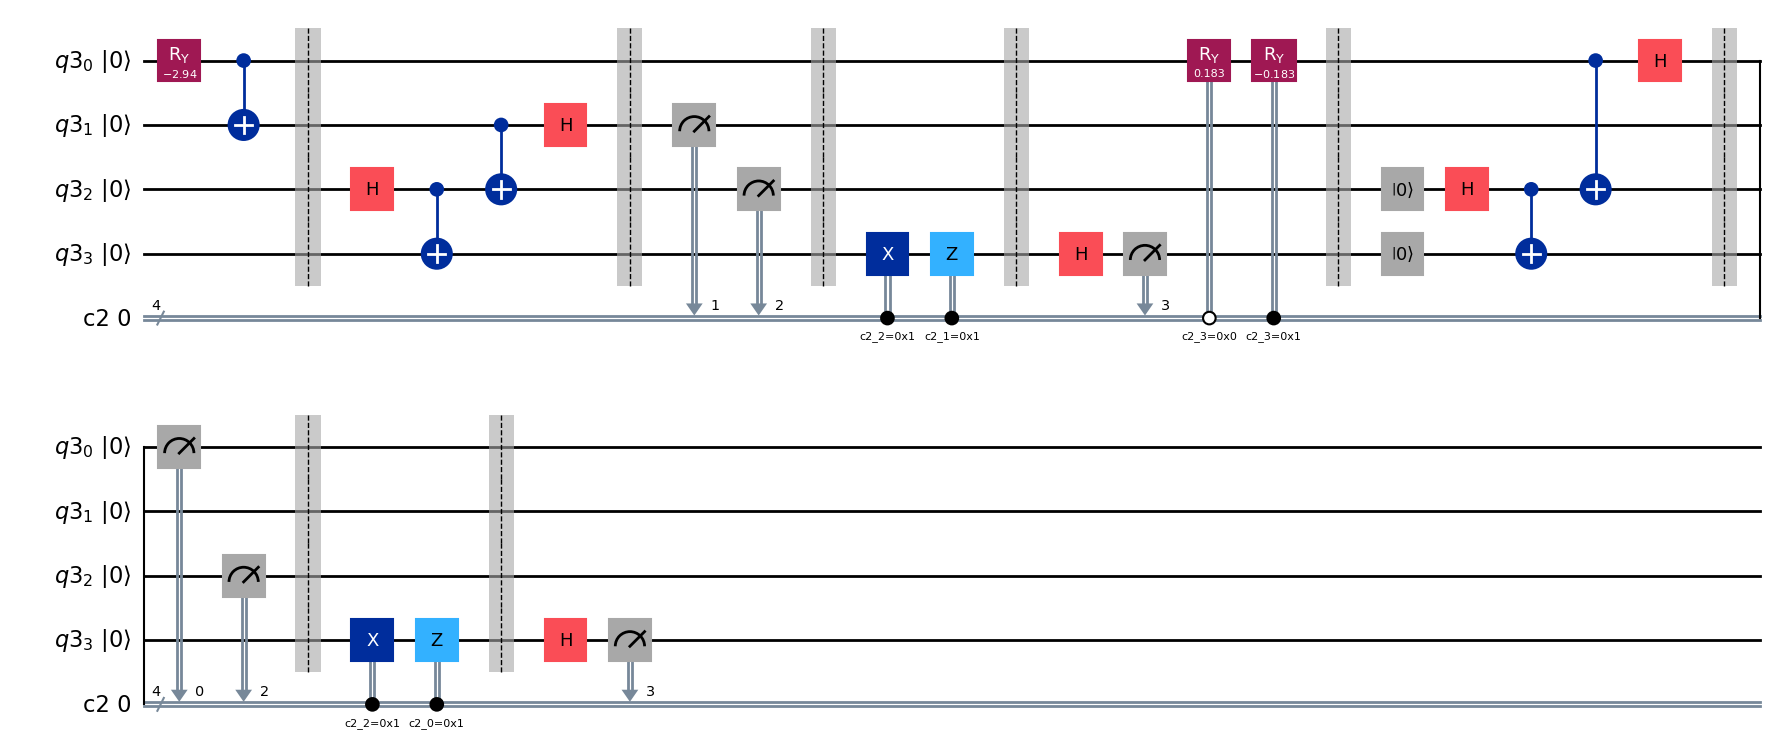

In [ ]:
qc = QuantumCircuit(qr, cr)

# Define the parameters (k, h)
k=0.2
h=1

#Prepare the ground state
alpha=-np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

qc.ry(2*alpha,qr[0])
qc.cx(qr[0],qr[1]) #0 is control and 1 is the target
qc.barrier()

## quantum state teleportation of qr[1]  to qr[3] (Alice)

# Step 1: Create an entangled pair between qr[2] and qr[3]
qc.h(qr[2]) # Apply Hadamard gate on qubit 2
qc.cx(qr[2],qr[3]) # Apply CNOT gate with qubit 2 as control and qubit 3 as target


# Step 2: Apply CNOT gate between qr[1] and qr[2] with qr[1] as control
qc.cx(qr[1],qr[2])

# Step 3: Apply Hadamard gate on qr[0]
qc.h(qr[1])
qc.barrier()

# Step 4: Measure qr[1] and qr[2]
qc.measure(qr[1],cr[1])
qc.measure(qr[2],cr[2]) # Measure qubit 1 and 2 and store result in classical bits 1 and 2
qc.barrier()

# Step 5: Apply conditional gates on qr[3] based on the measurement results
qc.x(qr[3]).c_if(cr[2], 1) # Apply X gate to qr[3] if cr[2] is 1
qc.z(qr[3]).c_if(cr[1], 1) # Apply Z gate to qr[3] if cr[1] is 1
qc.barrier()

qc.h(qr[3]) # For measurement in X Basis
qc.measure(qr[3], cr[3]) # Measure the teleported qubit (qr[3]) and store the result in cr[3]




## Conditional Operation of Bob on 2nd qubit (qr[1]) based on the result Alice got (u = -1 or 1)

# fucntion for calculating sin(2*phi)
def sin(k,h):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2) #formula for sin(2*phi)

#Bob calculates phi for conditional operation

phi=0.5*np.arcsin(sin(k,h))

# Conditional Operation

qc.ry(2*phi,qr[0]).c_if(cr[3], 0) #for positive value post measurement
qc.ry(-2*phi,qr[0]).c_if(cr[3], 1) #for negative value

qc.barrier()

## Bob Teleports the second qubit (qr[1]) to Alice

# We reset qr[2] and qr[3] so that we can reuse them for second teleportation

qc.reset(qr[2])
qc.reset(qr[3])

# QST of first qubit (qr[1]) to 4th qubit (qr[3]) i.e to Alice

# Step 1: Create an entangled pair between qr[2] and qr[3]
qc.h(qr[2]) # Apply Hadamard gate on qubit 2
qc.cx(qr[2],qr[3]) # Apply CNOT gate with qubit 2 as control and qubit 3 as target


# Step 2: Apply CNOT gate between qr[0] and qr[2] with qr[0] as control
qc.cx(qr[0],qr[2])

# Step 3: Apply Hadamard gate on qr[0]
qc.h(qr[0])
qc.barrier()

# Step 4: Measure qr[0] and qr[2]
qc.measure(qr[0],cr[0])
qc.measure(qr[2],cr[2]) # Measure qubit 0 and 2 and store result in classical bits 0 and 2
qc.barrier()

# Step 5: Apply conditional gates on qr[3] based on the measurement results
qc.x(qr[3]).c_if(cr[2], 1) # Apply X gate to qr[3] if cr[2] is 1
qc.z(qr[3]).c_if(cr[0], 1) # Apply Z gate to qr[3] if cr[0] is 1
qc.barrier()

# Alice measures the teleported qubit on X basis for caluclating V (interaction energy)

qc.h(qr[3])
qc.measure(qr[3], cr[3]) # Measure the teleported qubit (qr[3]) and store the result in cr[3]

qc.draw(output='mpl',initial_state = True)

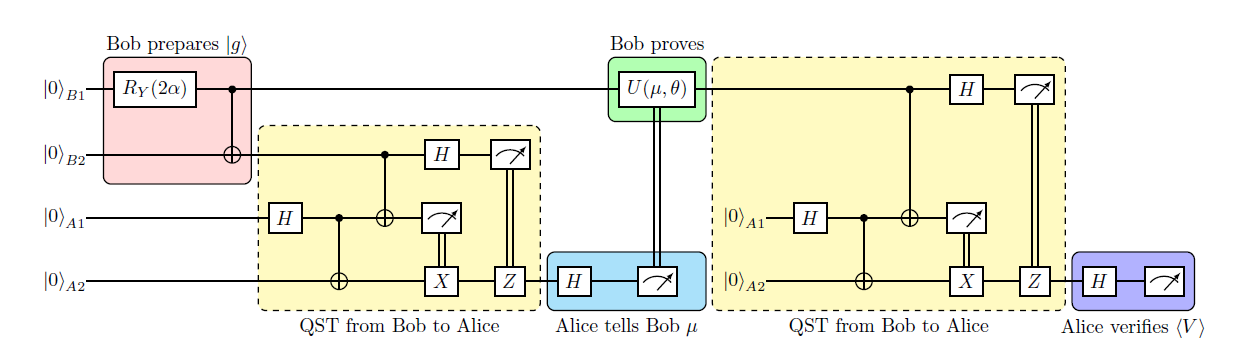

In [ ]:
# Transpile and run the circuit on a simulator
n_shots=100000

circ = transpile(qc, AerSimulator())
result = AerSimulator().run(circ, shots=n_shots).result()
counts = result.get_counts(circ)

## Energy Calculation

# We are interested in the state of qr[3] after the second teleportation and measurement.
# We can analyze the counts to determine the probability of measuring 0 or 1 in cr[3] after the second teleportation.

# Extract the counts for the cr[3] bit
cr3_counts = {}
for key, value in counts.items():
    cr3_value = key[-1]  # The last bit represents the measurement of cr[3]
    if cr3_value not in cr3_counts:       # If cr3_value = 0 [last bit of measurement is 0] and it is not in cr3_counts then this cr3_value = 0 will be initialized in cr3_counts with 0. i.e cr3_counts[0] = 0
        cr3_counts[cr3_value] = 0
    cr3_counts[cr3_value] += value

print("cr3_counts ['0'] = ",cr3_counts['0'])
print("cr3_counts ['1'] = ",cr3_counts['1'])

# Calculate the probabilities of measuring 0 or 1 in cr[3]
p_0 = cr3_counts.get('0', 0) / n_shots
p_1 = cr3_counts.get('1', 0) / n_shots



energy_qr3 = p_0 - p_1


print("Probability of measuring 0 in cr[3]:", p_0)
print("Probability of measuring 1 in cr[3]:", p_1)
print("Energy of qr[3] after measurement:", energy_qr3)

cr3_counts ['0'] =  50163
cr3_counts ['1'] =  49837
Probability of measuring 0 in cr[3]: 0.50163
Probability of measuring 1 in cr[3]: 0.49837
Energy of qr[3] after measurement: 0.0032600000000000406


# Quantum State Distinguishability (QSD)


In [ ]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)

<ipython-input-3-ff895bc4b27a>:61: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(qr[3]).c_if(cr[2], 1) # Apply X gate to qr[3] if cr[2] is 1
<ipython-input-3-ff895bc4b27a>:62: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(qr[3]).c_if(cr[1], 1) # Apply Z gate to qr[3] if cr[1] is 1
<ipython-input-3-ff895bc4b27a>:107: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(qr[1]).c_if(cr[2], 1)
<ipython-input-3-ff895bc4b27a>:108: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(qr[1]).c_if(cr[3], 1)


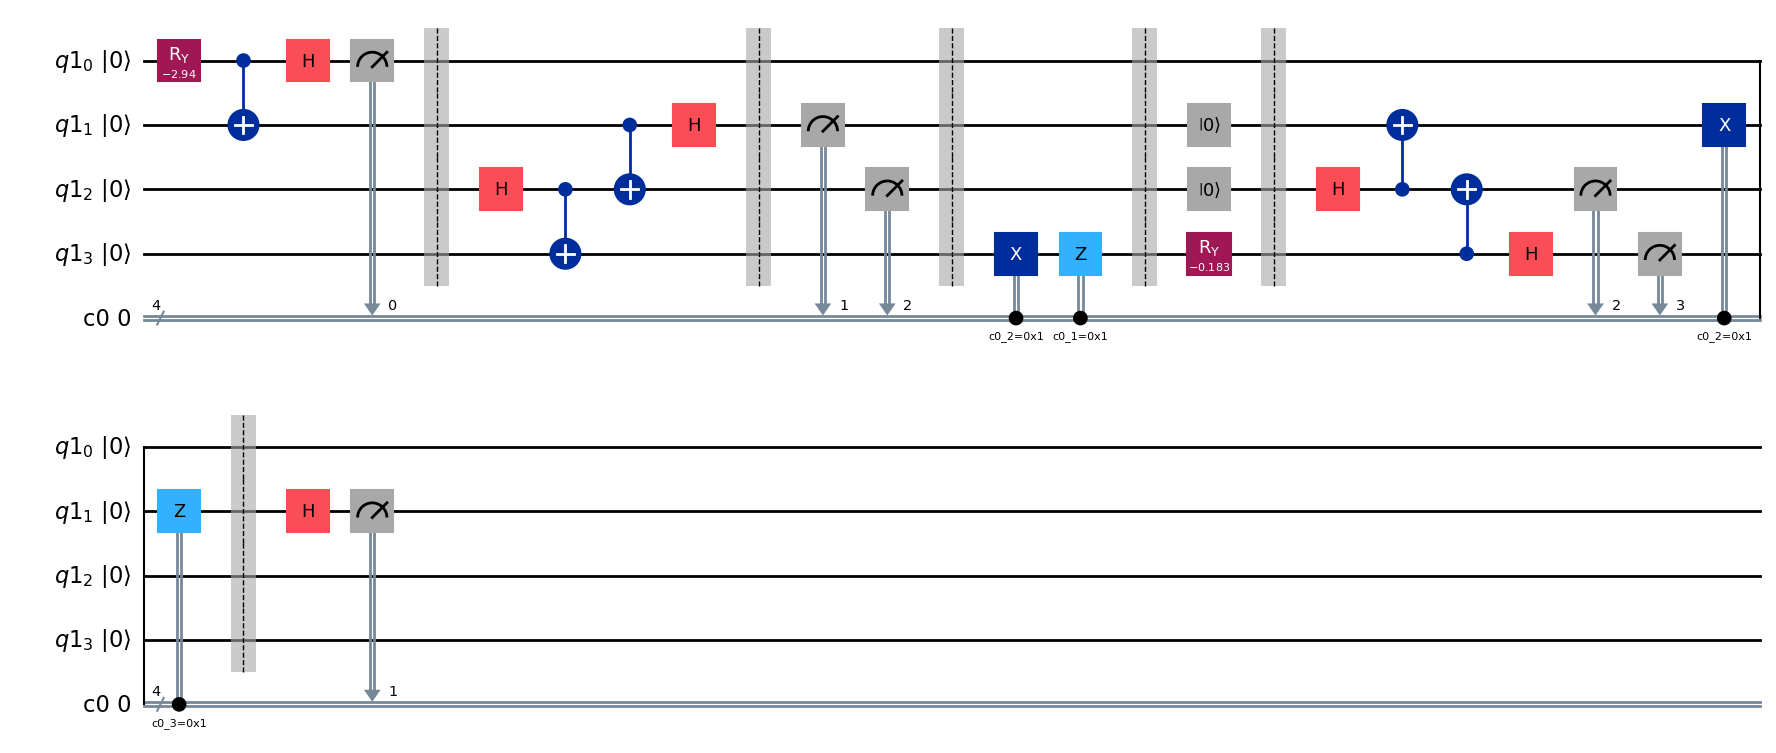

In [ ]:
qc = QuantumCircuit(qr, cr)

# Define the parameters (k, h)
k=0.2
h=1

# Bob (Prover) Prepares the ground state

alpha = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

qc.ry(2*alpha,qr[0])
qc.cx(qr[0],qr[1]) #0 is control and 1 is the target

# Bob (Prover) applies projective measurement

qc.h(qr[0])
qc.measure(qr[0], cr[0])

# Bob records the μ value. cr[0] = 0----> μ = 1, cr[0] = 1----> μ = -1

if cr[0] == '0':
    mu = 1
else:
    mu = -1

qc.barrier()

## Bob Calculates phi

# fucntion for calculating sin(2*theta)
def sin(k,h):
    return (h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2) #formula for sin(2*theta)

phi_bob = 0.5*np.arcsin(sin(k,h))

## Bob tells Alice the value of μ (result of Bob's projective measurement) and phi

phi_alice = phi_bob
v = mu

## Bob teleports qr[1] to qr[3] (Alice)

# Step 1: Create an entangled pair between qr[2] and qr[3]
qc.h(qr[2]) # Apply Hadamard gate on qubit 2
qc.cx(qr[2],qr[3]) # Apply CNOT gate with qubit 2 as control and qubit 3 as target


# Step 2: Apply CNOT gate between qr[1] and qr[2] with qr[1] as control
qc.cx(qr[1],qr[2])

# Step 3: Apply Hadamard gate on qr[0]
qc.h(qr[1])
qc.barrier()

# Step 4: Measure qr[1] and qr[2]
qc.measure(qr[1],cr[1])
qc.measure(qr[2],cr[2]) # Measure qubit 1 and 2 and store result in classical bits 1 and 2
qc.barrier()

# Step 5: Apply conditional gates on qr[3] based on the measurement results
qc.x(qr[3]).c_if(cr[2], 1) # Apply X gate to qr[3] if cr[2] is 1
qc.z(qr[3]).c_if(cr[1], 1) # Apply Z gate to qr[3] if cr[1] is 1
qc.barrier()



## Conditional Operation of Alice on (qr[3]) randomly (Alice chooses μ = 1 or μ = -1 randomly, we denote Alice's μ as v)

# Conditional Operation

f = 1 # For faithful conditional operation, set f = 1 ; for unfaithful conditional operation set f = - 1

v = f*mu


# v = random.randint(0, 1) # 0--> v = 1, 1--> v = -1

if v == 1:
    qc.ry(2*phi_alice,qr[3])  # μ = 1

else:
    qc.ry(-2*phi_alice,qr[3]) # μ = -1


# Reset qr[1] and qr[2] so that we can use them to teleport qr[3] to qr[1](to Bob)

qc.reset(qr[1])
qc.reset(qr[2])

qc.barrier()

## Alice teleports qr[3] to qr[1](to Bob)

# Create entanglement between qr[2] and qr[1]
qc.h(qr[2])
qc.cx(qr[2], qr[1])

# Entangle qr[3] with qr[2]
qc.cx(qr[3], qr[2])
qc.h(qr[3])

# Measure qr[3] and qr[2]
qc.measure(qr[3], cr[3])
qc.measure(qr[2], cr[2])

# Apply corrections to qr[1] based on measurements
qc.x(qr[1]).c_if(cr[2], 1)
qc.z(qr[1]).c_if(cr[3], 1)

qc.barrier()

# Bob Measures X2 for calculating V

qc.h(qr[1])
qc.measure(qr[1], cr[1]) # Measure the teleported qubit (qr[1]) and store the result in cr[1]


# fucntion for calculating cos(2*theta)
def cos(k,h):
    return (h*h+2*k*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2) #formula for cos(2*theta)


## Energy Calculation (Analytical Formula)

def H_energy(k,h):
    return (h*(2*k*sin(k,h)+h*(1-cos(k,h))))/4*np.sqrt(h**2+k**2)

def V_energy(k,h):
    return (k*(-h*sin(k,h)+k*(1-cos(k,h))))/np.sqrt(h**2+k**2)



qc.draw(output='mpl',initial_state = True)

In [ ]:
# Transpile and run the circuit on a simulator

n_shots=100000

circ = transpile(qc, AerSimulator())
result = AerSimulator().run(circ, shots=n_shots).result()
counts = result.get_counts(circ)



Interacting energy V -0.0011615459447263943




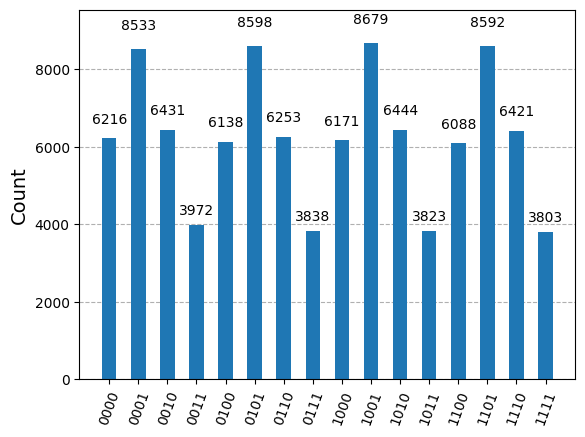

In [ ]:
## Energy Calculation

V=(2*k**2)/(np.sqrt(h**2+k**2)) #calculates the initial interacting energy value

for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1] # Reverses the order to match the qubit indices (is this needed in the current qiskit version?)

        V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots # updates V based on both bits of measurement. bit_string[0] = measurement result of qr[0] ; bit_string[1] = measurement result of qr[1]




print("\nInteracting energy V",V)
print("\n")


plot_histogram(counts)

In [ ]:
## Bob's (Prover's) decision

if V < 0:
  f_decision = 1
  print("\nBob's (Prover's) decision of Alice's Conditional Operation: Faithful")
else:
  f_decision = -1
  print("\nBob's (Prover's) decision of Alice's Conditional Operation: Unfaithful")

## Actual Scenario

if f == 1:
  print("\nActual Scenario: Alice is faithful")
else:
  print("\nActual Scenario: Alice is unfaithful")

## Alice's (verifier's) decision

if f_decision == f:
  print("\nAlice's (Verifier's) Decision: Alice Accepts")
else:
  print("\nAlice's (Verifier's) Decision: Alice Rejects")




Bob's (Prover's) decision of Alice's Conditional Operation: Faithful

Actual Scenario: Alice is faithful

Alice's (Verifier's) Decision: Alice Accepts
